### The University of Melbourne, School of Computing and Information Systems
# COMP90086 Computer Vision, 2021 Semester 2

## Assignment 3

**Student Name:**    `Ankita Dhar`

**Student ID:**     `1154197`

This iPython notebook is a template which you should use for your Assignment 3 submission. This file should be submitted at the **Assignment 3: Code** link on the LMS, along with any images needed to run your code.

In addition to this file, you should submit a writren report explaining your results at the **Assignment 3: Report** link on the LMS. Please see the assignment specification for details on what must be included in the report for each question.

*Adding proper comments to your code is MANDATORY.*

### 1. Detect lines in the image
Use the Canny edge detector and Hough transform to detect lines in the image.

#### Referring Worksheet of Workshop 7

In [1]:
import os
import numpy as np
import cv2  
from matplotlib import pyplot as plt
import shapely
from shapely.geometry import LineString, Point
import sys
import math
import pandas as pd

In [2]:
def findCannyEdge(img) :
    """ 
    :purpose find edges of a given image
    :param img image path
    :return lines detected by Hough transform after 
                  finding edges using Canny module from OpenCV
            img image
    """
    rootpath='./'
    # read in an image from a filepath as graycsale.
    img = cv2.imread(os.path.join(rootpath, img),cv2.IMREAD_UNCHANGED)

    # remove noise
    img = cv2.GaussianBlur(img, (5,5), 0)

    # Canny edge detection with OpenCV
    edge_img = cv2.Canny(img,100,200,apertureSize=3,L2gradient=True) #two thresholds in Hysteresis Thresholding and Aperture size of the Sobel

    # Set the Figure size of plotting
    plt.subplots(figsize=(15, 15)) 

    plt.subplot(1,2,1)
    plt.imshow(img, cmap='gray')  
    plt.title('Original image')
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(edge_img, cmap='gray')  
    plt.title('Canny edge map')
    plt.axis('off')

    plt.show() 
    
    #Implement Hough transform to detect lines in a Canny edge map 

    # Finds lines in a binary image using the standard Hough transform
    lines = cv2.HoughLines(edge_img, 1, np.pi/180, 100) 
    # This function outputs vector of detected lines.
    
    return lines, img

In [3]:
def plotLinesToVanishingPt(lines, img):
    """ 
    :purpose filter horizontal and vertical lines from the lines from Hough Transform
    :param lines generated from Hough Transform
    :param img image which generated the lines
    :return edges which are filtered lines
    """
    # To better distinguish the detected lines from the background, 
    # we will draw the lines in colour. 
    # Therefore, we first convert the grayscale map to RGB format.
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    color_img = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB) 
    
    edges = []

    # Display by drawing the lines
    for line in lines:
        # Each line is represented by a vector (ρ,θ). 
        # Whereas ρ/rho is the distance from the coordinate origin (0,0) 
        # and θ/theta is the line rotation angle in radians ( 0∼vertical line,π/2∼horizontal line ).
        rho,theta = line[0]
#         print (theta)

        if abs(theta-np.pi/90) < np.pi/9:
            continue
            
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho

        x1, y1 = int(x0 + 1000*(-b)),int(y0 + 1000*(a))
        x2, y2 = int(x0 - 1000*(-b)),int(y0 - 1000*(a))
                
        if abs(y2-y1) < 500 or abs(x2-x1) < 500: continue
        
        # we store the two end points of each line for later use
        edges.append([(x1,y1),(x2,y2)])

        cv2.line(color_img,(x1,y1),(x2,y2),(255,0,0),2)

    plt.imshow(color_img) 
    plt.title("Detected Lines (in red)")
    plt.axis('off')

    plt.show()
    return edges

### 2. Locate the vanishing point
Use RANSAC to locate the vanishing point from the detected lines.

#### 2.1 RANSAC functions
Define two fuctions required by RANSAC: a function to find the point where lines intersect, and a function to compute the distance from a point to a line.

In [4]:
# Find the intersection point
def find_intersection_point(line1, line2):
    """
    :purpose to find intersection between two given lines using shapely module
    :param line1 two end points of first line
    :param line2 two end points of second line
    :return the point of intersection of the lines
    """
    line1 = LineString([line1[0], line1[1]])
    line2 = LineString([line2[0], line2[1]])

    int_pt = line1.intersection(line2)
    
    if str(int_pt)=="LINESTRING EMPTY": 
        # if no intersection point is found return tuple of None values
        return (None, None)
    
    return (int_pt.x, int_pt.y)
    
# Find the distance from a point to a line
# def find_dist_to_line():
def find_dist_to_line(m, c, x0, y0):
    """ 
    :purpose to find an intercept point of the line model with
        a normal from point (x0,y0) to it, return
        distance between point (x0, y0) and intercept
    :param m slope of the line model
    :param c y-intercept of the line model
    :param x0 point's x coordinate
    :param y0 point's y coordinate
    :return intercept point
    """
 
    # intersection point with the model
    x = (x0 + m*y0 - m*c)/(1 + m**2)
    y = (m*x0 + (m**2)*y0 - (m**2)*c)/(1 + m**2) + c
    dist = math.sqrt((x - x0)**2 + (y - y0)**2)
 
    return dist


#### 2.2 RANSAC loop
Define the main RANSAC loop

In [5]:
def find_line_model(ptA, ptB):
    """ 
    :purpose to find a line model for the given points
    :param points selected points for model fitting
    :return line model
    """
 
    # [WARNING] vertical and horizontal lines should be treated differently
    #           here we just add some noise to avoid division by zero
 
    # find a line model for these points
    m = (ptB[1] - ptA[1]) / (ptB[0] - ptA[0] + sys.float_info.epsilon)  # slope (gradient) of the line
    c = ptB[1] - m * ptB[0]                                     # y-intercept of the line
 
    return m, c

In [6]:
def ransac_plot(img, model_lines):
    """ 
    :purpose to plot the gray-scaled image with the 
        lines intersecting at forming vanishing point
    :param img image
    :param model-lines line
    """
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    color_img = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB) 
    
    # Display by drawing the lines
    for line in model_lines:
        
        cv2.line(color_img,line[0],line[1],(255,0,0),2)

    plt.imshow(color_img) 
    plt.title("Detected Lines (in red)")
    plt.axis('off')

    plt.show()


In [7]:
def ransacLoop(edges, img):
    """ 
    :purpose to find the best model to find vanishing point
    :param edges of the image
    :param img image
    :return model_vanishing_pt best model's vanishing point
    """
    ransac_ratio = 0.8
    n_samples = len(edges)
    w = 0.5
    ransac_iterations = np.log(1-ransac_ratio)/np.log(1-(w**10))
    ransac_threshold = 5
    
    ratio = 0.
    model_vanishing_pt = None

    # perform RANSAC iterations
    for it in range(int(ransac_iterations)):

        # randomly sample N points
        n = 2

        np.random.shuffle(edges)

        sample_edges = edges[:n]
        test_edges = edges[n:]

        # find the intersecting point of the sampled edges
        ints_x, ints_y = find_intersection_point(sample_edges[0], sample_edges[1])

        if not ints_x: continue

        model_lines = sample_edges
        num = 0
        
        if not model_vanishing_pt: model_vanishing_pt = (ints_x, ints_y)

        # count the number of inliers num
        # inliers are points whose distance to the line is less than ransac_threshold
        for edge in test_edges:

            m, c = find_line_model(edge[0], edge[1])
            dist = find_dist_to_line(m, c, ints_x, ints_y)

            # check whether it's an inlier or not
            if dist < ransac_threshold:
                model_lines.append(edge)
                num += 1

        # if this value of num is higher than previously saved value,
        # save it, and save the current model parameters
        if num/float(n_samples) > ratio:
            ratio = num/float(n_samples)
            model_vanishing_pt = (ints_x, ints_y)

        # we are done in case we have enough inliers
        if num > n_samples*ransac_ratio:
            print('The model is found !')
            break

    # plot the final model
    ransac_plot(img, model_lines)

    print('\nFinal model:\n')
    print('  ratio = ', ratio)
    print('  model vanishing point = ', model_vanishing_pt)
    
    return model_vanishing_pt
    


In [8]:
data= pd.read_csv("vanishing_points.csv")

### 3. Main function and evaluation
Run your vanishing point detection method on a folder of images, return the (x,y) locations of the vanishing points, and evaluate the result.

In [9]:
def load_images(folder):
    """ 
    :purpose to read all file-names from a folder
    :param folder to read from
    :return files list of file-names
    """
    files=[]
    for file in os.listdir(folder):
        files.append(file)
        img = cv2.imread(os.path.join(folder,file))
    return files

In [10]:
def main():
    """ 
    :purpose main function to find the vanishing point of each image and find the mean squared error
    """
    imgNames=load_images('./images')

    mse = 0

    for i in range(len(data)):
        lines, img = findCannyEdge('./images/'+data["image"][i])
        edges = plotLinesToVanishingPt(lines, img)
        v_pt = ransacLoop(edges, img)

        if v_pt != None:
            error=((data["x"][i]-v_pt[0])**2 +(data["y"][i]-v_pt[1])**2)**0.5
            mse += error
            print("error: "+str(error))

    print("mse: "+str(mse/len(data)))

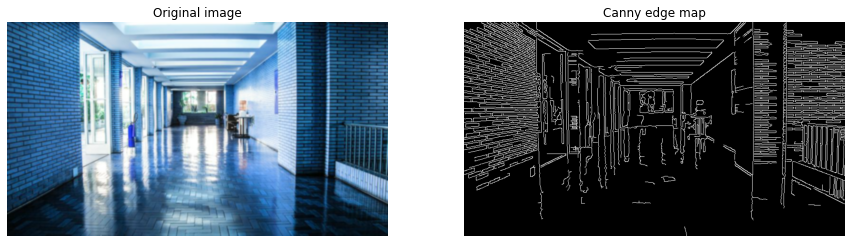

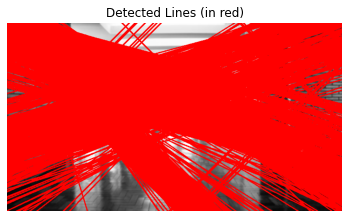

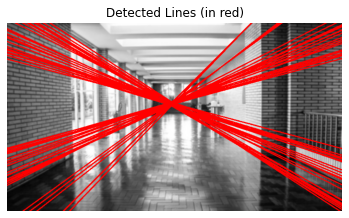


Final model:

  ratio =  0.09672830725462304
  model vanishing point =  (402.84044646370694, 184.88888491396273)
error: 2.2164048866860315


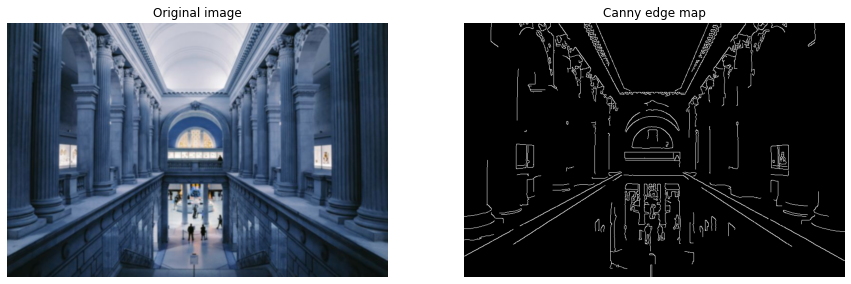

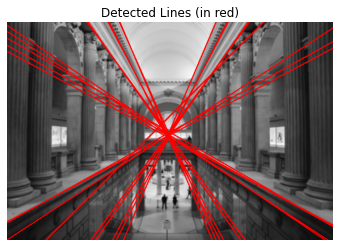

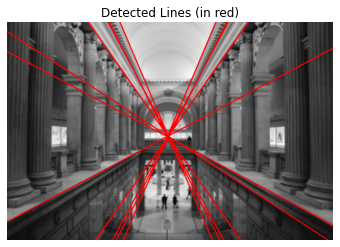


Final model:

  ratio =  0.8
  model vanishing point =  (394.5272772225904, 277.01688871903497)
error: 1.7896857394530652


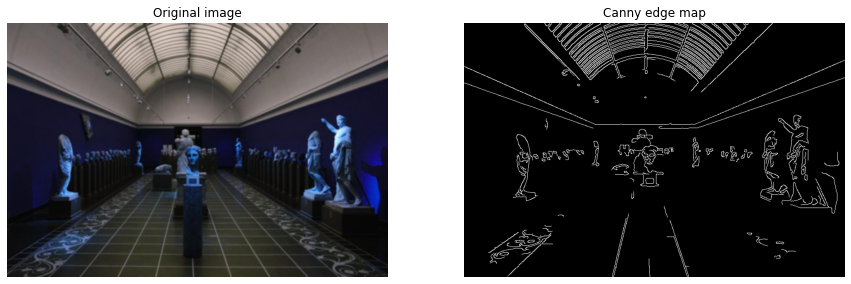

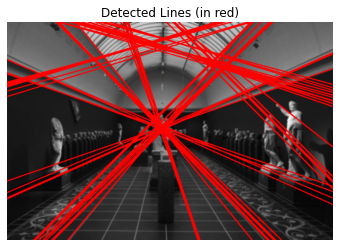

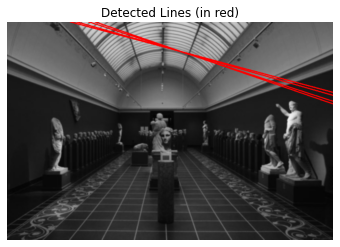


Final model:

  ratio =  0.37735849056603776
  model vanishing point =  (377.9529842560244, 259.1904836888783)
error: 1.1914117229853423


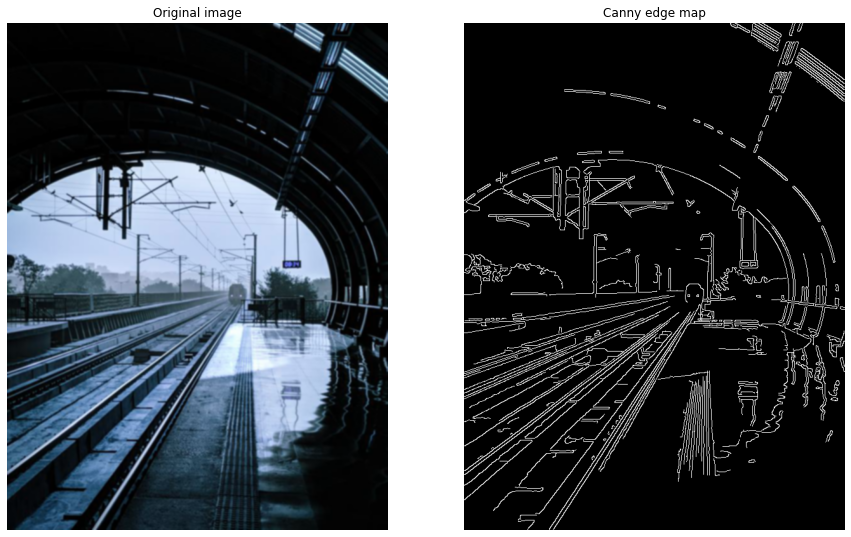

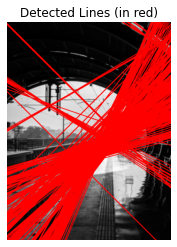

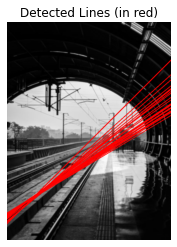


Final model:

  ratio =  0.19117647058823528
  model vanishing point =  (355.1301596567744, 432.8985572326409)
error: 25.840872920606735


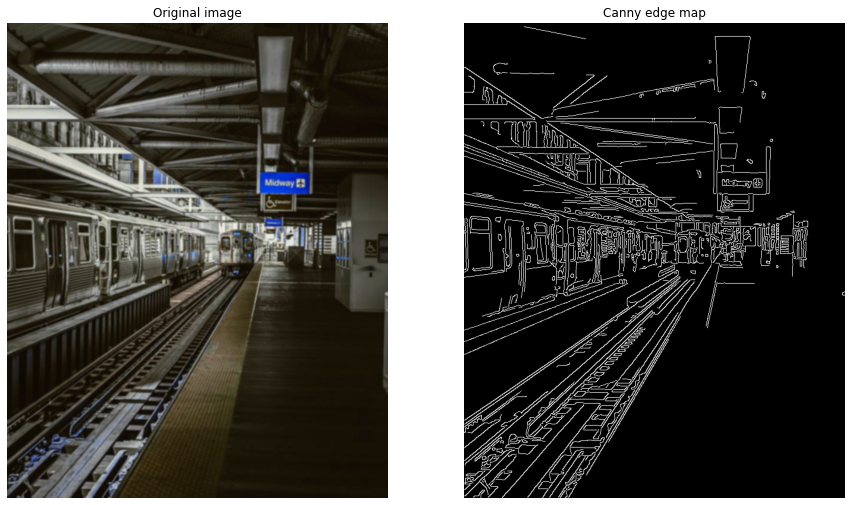

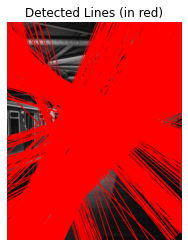

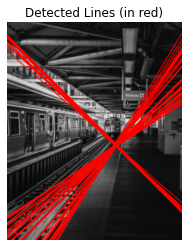


Final model:

  ratio =  0.08907741251325557
  model vanishing point =  (412.5644271236182, 341.25673993590374)
error: 36.18955382810657


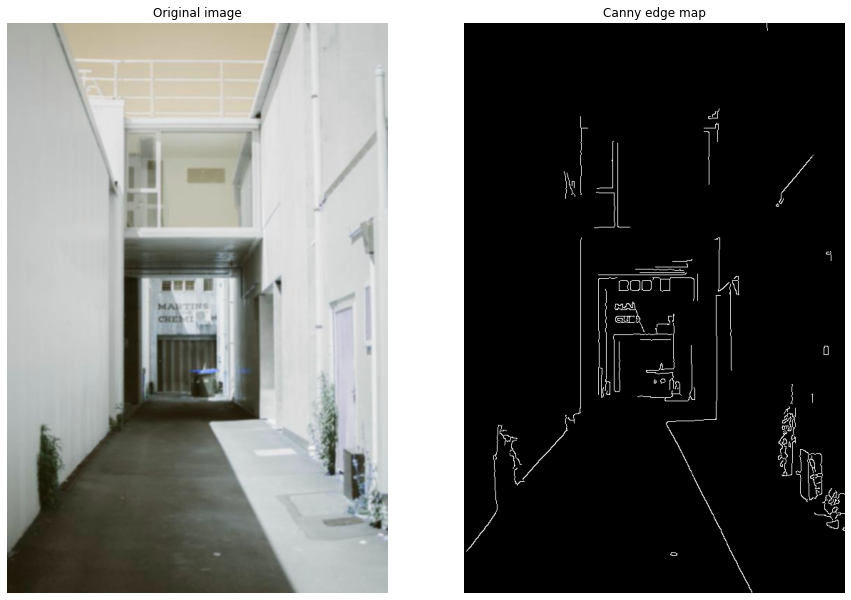

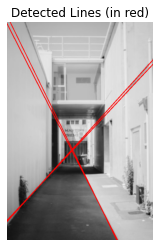

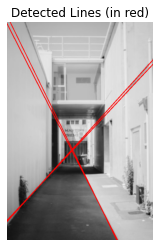


Final model:

  ratio =  0.5
  model vanishing point =  (235.76944292147297, 469.3697660894635)
error: 5.4085984036877095


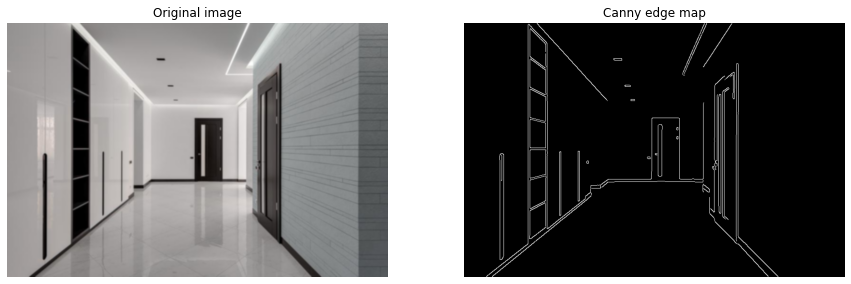

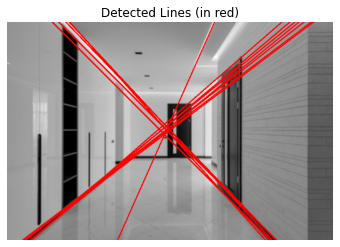

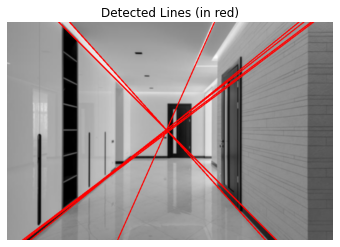


Final model:

  ratio =  0.46153846153846156
  model vanishing point =  (391.9836403761274, 262.0318237062624)
error: 2.8395662899697958


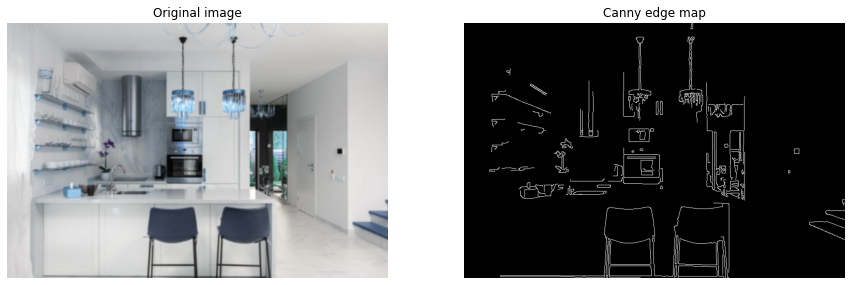

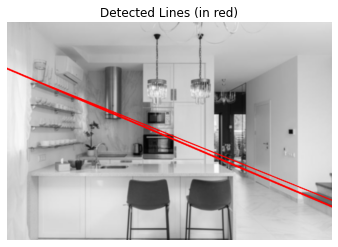

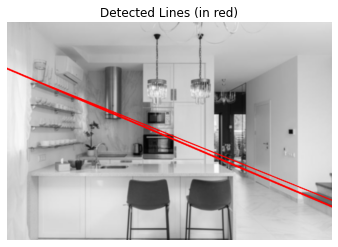


Final model:

  ratio =  0.3333333333333333
  model vanishing point =  (85.90200573065903, 149.79541547277938)
error: 313.0923065677559


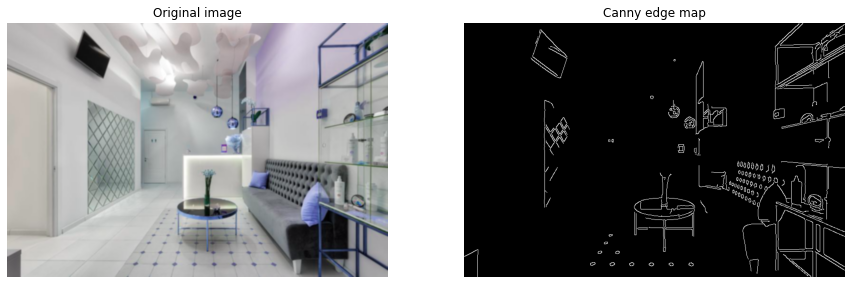

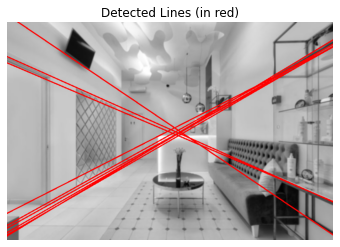

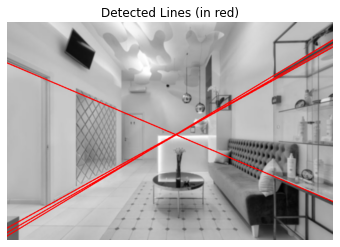


Final model:

  ratio =  0.4444444444444444
  model vanishing point =  (426.3763737863118, 269.19457424219087)
error: 10.40758586823095


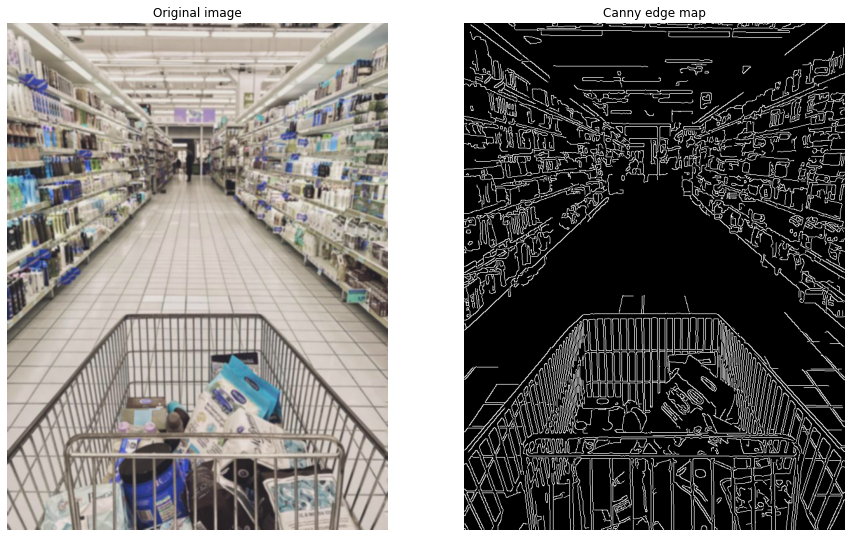

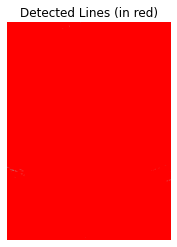

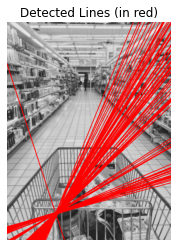


Final model:

  ratio =  0.04339662007093678
  model vanishing point =  (278.0386821715776, 562.1446157293641)
error: 349.42364128420326


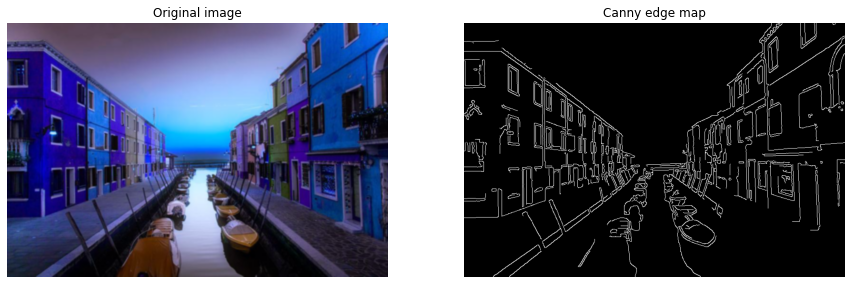

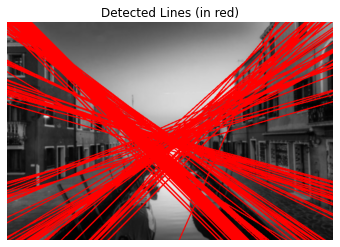

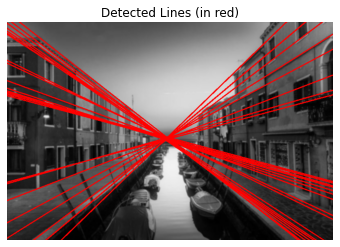


Final model:

  ratio =  0.2641509433962264
  model vanishing point =  (394.64145535092354, 285.7930252962461)
error: 11.570966851913155


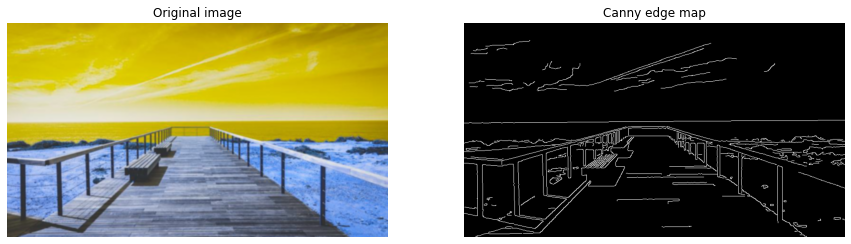

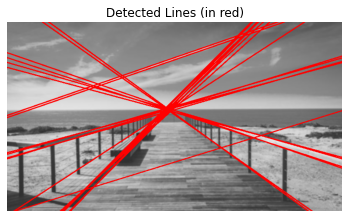

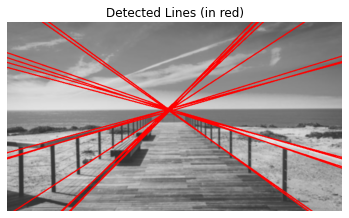


Final model:

  ratio =  0.6666666666666666
  model vanishing point =  (381.12085016324477, 208.55225251964742)
error: 7.898479916762271
mse: 63.9890895233634


In [11]:

if __name__ == "__main__":
    main()